# Предсказание стоимости вина

In [376]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn

#### Описание задачи

Рассмотреть зависимость стоимости вина от физических и вкусовых характеристик, указанных на специализированных сайтах и интернет-магазинах. Использовать модель линейной регрессии для предсказания цены на вино, используя выявленную в ходе анализа зависимость.

## 1. Загрузка данных

Загружаем файл по ссылке. Данные взяты с Kaggle (https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset/data)

In [377]:
url = "https://raw.githubusercontent.com/mkhorosh/ml-unn/refs/heads/main/wines_SPA.csv"
data_raw = pd.read_csv(url)
data_raw.shape

(7500, 11)

Набор данных содержит информацию о 7500 различных типах красных вин из Испании и включает 11 характеристик, описывающих их цену, рейтинг, а также некоторые аспекты вкусовых качеств. Данные были собраны автором с использованием веб-скрейпинга из различных источников (от специализированных сайтов о вине до интернет-магазинов).

In [378]:
data_raw.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [379]:
data_raw.tail()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
7495,Contino,Reserva,2016,4.2,392,Espana,Rioja,19.98,Rioja Red,4.0,3.0
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Espana,Priorato,16.76,Priorat Red,4.0,3.0
7497,Mustiguillo,Finca Terrerazo,2017,4.2,390,Espana,El Terrerazo,24.45,Red,4.0,3.0
7498,Matarromera,Gran Reserva,2011,4.2,389,Espana,Ribera del Duero,64.50,Ribera Del Duero Red,5.0,3.0
7499,Sei Solo,Preludio,2016,4.2,388,Espana,Ribera del Duero,31.63,Ribera Del Duero Red,5.0,3.0


In [380]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


Столбцы(признаки):

* `winery` — Название винодельни (String)
* `wine` — Название вина (String)
* `year` — Год, в котором был собран виноград (String)
* `rating` — Средняя оценка, данная вину пользователями [от 1-5] (Float)
* `num_reviews` — Количество пользователей, которые оценили вино (Integer)
* `country` — Страна происхождения [Espana] (String)
* `region` — Регион производства вина (String)
* `price` — Цена в евро [€] (Float)
* `type` — Сорт вина (String)
* `body` — Оценка тела, определяемая как насыщенность и вес вина во рту [от 1 до 5] (Float)
* `acidity` — показатель кислотности, определяемый как “морщинистость” вина или терпкость; это то, что делает вино освежающим, а ваш язык наполняется слюной и хочется сделать еще глоток [от 1 до 5] (Float)

In [381]:
numerical_features = data_raw.select_dtypes(include=['float64', 'int64']).columns
print("Числовые признаки:", numerical_features)

categorical_features = data_raw.select_dtypes(include=['object']).columns
print("Нечисловые признаки:", categorical_features)

Числовые признаки: Index(['rating', 'num_reviews', 'price', 'body', 'acidity'], dtype='object')
Нечисловые признаки: Index(['winery', 'wine', 'year', 'country', 'region', 'type'], dtype='object')


Заменим тип Object у столбцов на специальный тип, предназначенный для хранения категориальных значений

In [382]:
data_raw['winery'] = data_raw['winery'].astype('category')
data_raw['wine'] = data_raw['wine'].astype('category')
data_raw['country'] = data_raw['country'].astype('category')
data_raw['region'] = data_raw['region'].astype('category')
data_raw['type'] = data_raw['type'].astype('category')

In [383]:
data_raw.describe(include=['category'])

,winery,wine,country,region,type
count,7500,7500,7500,7500,6955
unique,480,847,1,76,21
top,Contino,Reserva,Espana,Rioja,Rioja Red
freq,457,467,7500,2440,2357


Найдём уникальные значения в каждом из столбцов данных

In [384]:
distinct_values = data_raw.T.apply(lambda x: x.unique(), axis=1)
print(distinct_values)

winery         [Teso La Monja, Artadi, Vega Sicilia, Pago de ...
wine           [Tinto, Vina El Pison, Unico, Unico Reserva Es...
year           [2013, 2018, 2009, 1999, 1996, 1998, 2010, 199...
rating                  [4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2]
num_reviews    [58, 31, 1793, 1705, 1309, 1209, 1201, 926, 64...
country                                                 [Espana]
region         [Toro, Vino de Espana, Ribera del Duero, Monti...
price          [995.0, 313.5, 324.95, 692.96, 778.06, 490.0, ...
type           [Toro Red, Tempranillo, Ribera Del Duero Red, ...
body                                   [5.0, 4.0, 3.0, nan, 2.0]
acidity                                     [3.0, 2.0, 1.0, nan]
dtype: object


Удаляем столбец country потому что он имеет одно уникальное значение

In [385]:
data = data_raw
data = data.drop(['country'], axis = 1)
data['year'] = data['year'].replace('N.V.', np.NaN)
data.shape

(7500, 10)

## 2. Визуализация данных и описательная статистика

In [386]:
data.describe()

,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


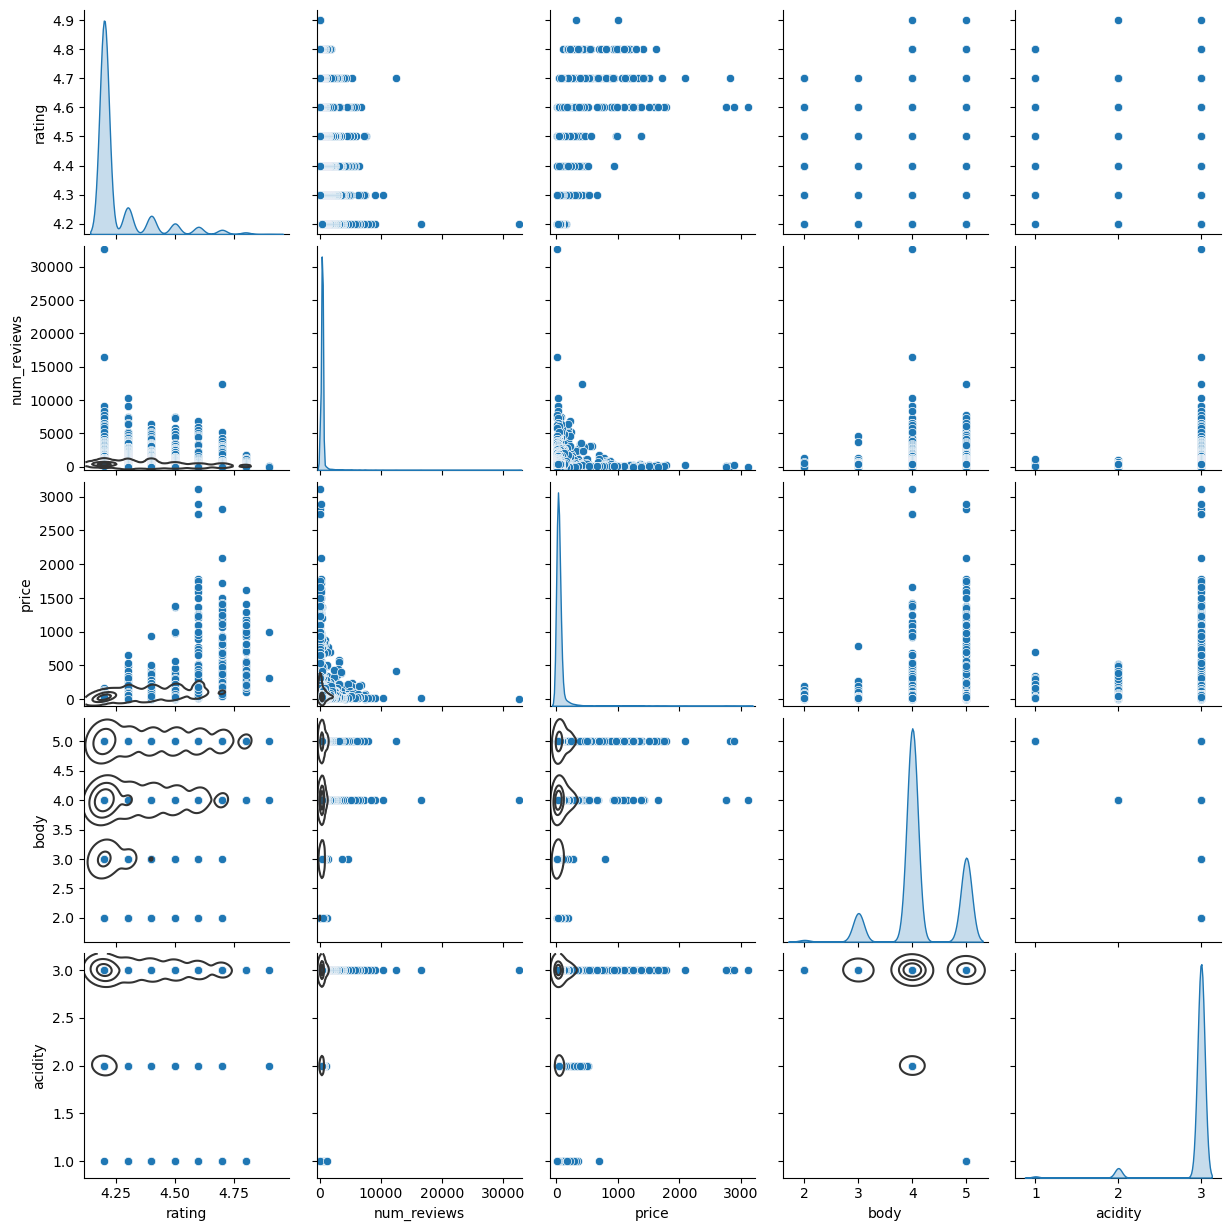

In [387]:
g = sns.pairplot(data=data, diag_kind="kde", dropna=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")

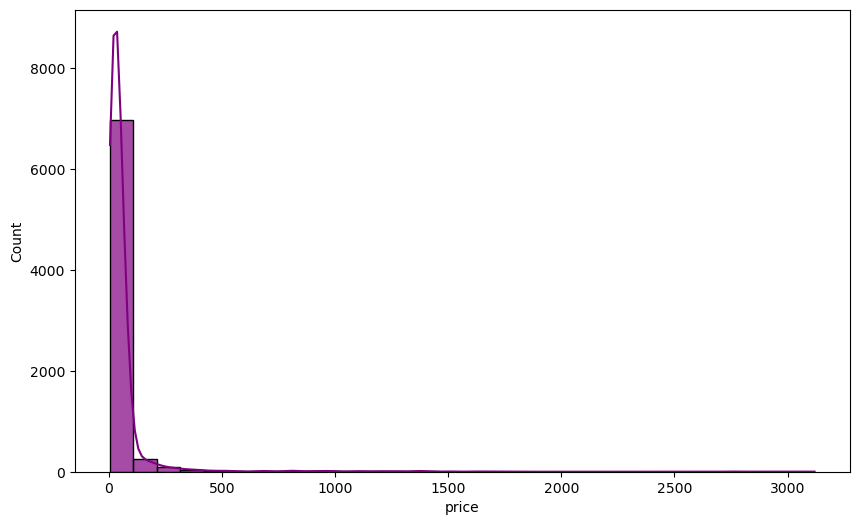

<Axes: >

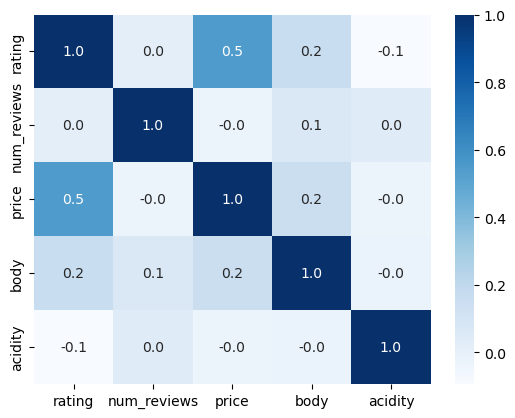

In [388]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True, color="purple", alpha=0.7)
plt.show()

sns.heatmap(data[numerical_features].corr(),annot=True, cmap='Blues', fmt='.1f')


Наблюдается некая корреляция между ценой и рейтингом вина. Корреляяционная матрица холодная, посмотрим результат после обработки данных.

<Axes: xlabel='rating', ylabel='price'>

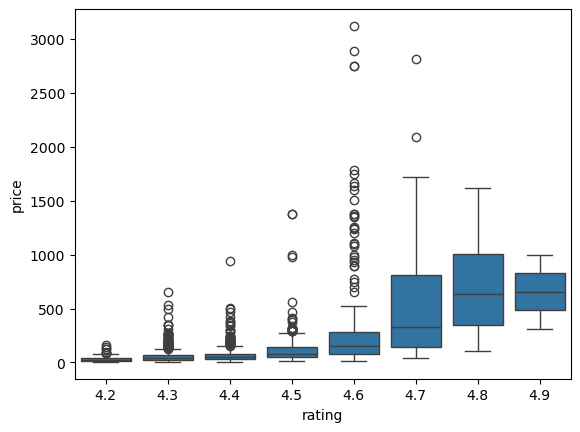

In [389]:
sns.boxplot(x=data["rating"],y=data['price'])

## 3. Борьба с выбросами

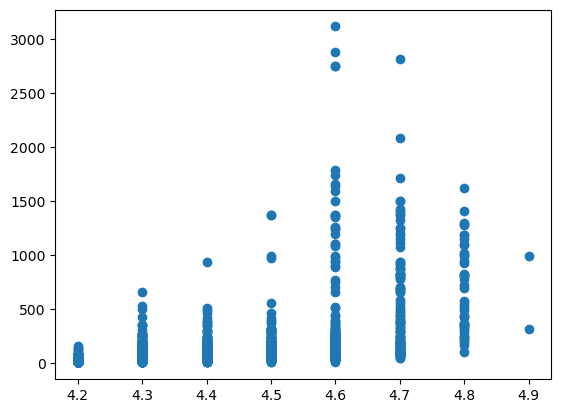

In [390]:
plt.scatter(data['rating'], data['price'])
pass

Удалим все строки таблицы, в которых `price` выходит за пределы квантилей (очень вероятно, что общие тенденции не работают для вин огромной цены (> 2000 €)).

In [391]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_no_outliers = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

print(f"До удаления выбросов: {data.shape[0]} строк.")
print(f"После удаления выбросов: {data_no_outliers.shape[0]} строк.")

До удаления выбросов: 7500 строк.
После удаления выбросов: 6962 строк.


In [392]:
data = data_no_outliers
data.shape

(6962, 10)

## 4. Заполнение пропущенных значений

In [393]:
data.isna().sum()  

winery            0
wine              0
year            276
rating            0
num_reviews       0
region            0
price             0
type            540
body           1155
acidity        1155
dtype: int64

In [394]:
data = data.dropna(subset=['year'])

data.shape

(6686, 10)

In [395]:
data.isna().sum()

winery            0
wine              0
year              0
rating            0
num_reviews       0
region            0
price             0
type            533
body           1126
acidity        1126
dtype: int64

In [396]:
type_counts = data['type'].value_counts()

print(type_counts)

type
Rioja Red               2252
Ribera Del Duero Red    1210
Red                      827
Priorat Red              595
Toro Red                 272
Tempranillo              261
Albarino                 252
Mencia                   231
Rioja White               88
Cava                      30
Grenache                  29
Verdejo                   26
Monastrell                18
Syrah                     15
Montsant Red              11
Cabernet Sauvignon        11
Pedro Ximenez              9
Chardonnay                 9
Sauvignon Blanc            4
Sparkling                  3
Sherry                     0
Name: count, dtype: int64


In [397]:
import numpy as np

# Заполнение пропусков NaN в 'type' на основе моды по каждому региону
data['type'] = data.groupby('region', observed=False)['type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
data = data.dropna(subset=['type'])

C:\Users\Marina\AppData\Local\Temp\ipykernel_14712\3955762085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data.groupby('region', observed=False)['type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


In [398]:
type_counts = data['type'].value_counts()

print(type_counts)

type
Rioja Red               2253
Red                     1312
Ribera Del Duero Red    1212
Priorat Red              604
Toro Red                 273
Tempranillo              261
Albarino                 253
Mencia                   236
Rioja White               88
Cava                      30
Grenache                  29
Verdejo                   26
Monastrell                18
Cabernet Sauvignon        16
Syrah                     15
Montsant Red              11
Chardonnay                10
Pedro Ximenez              9
Sparkling                  5
Sauvignon Blanc            4
Sherry                     0
Name: count, dtype: int64


In [399]:
data.isna().sum()

winery            0
wine              0
year              0
rating            0
num_reviews       0
region            0
price             0
type              0
body           1105
acidity        1105
dtype: int64

In [400]:
# Заполнение пропусков в 'body' на основе 'type'
data['body'] = data.groupby('type')['body'].transform(lambda x: x.fillna(x.mean()))

# Заполнение пропусков в 'acidity' на основе 'type'
data['acidity'] = data.groupby('type')['acidity'].transform(lambda x: x.fillna(x.mean()))


C:\Users\Marina\AppData\Local\Temp\ipykernel_14712\2327676789.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['body'] = data.groupby('type')['body'].transform(lambda x: x.fillna(x.mean()))
C:\Users\Marina\AppData\Local\Temp\ipykernel_14712\2327676789.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['acidity'] = data.groupby('type')['acidity'].transform(lambda x: x.fillna(x.mean()))


In [401]:
data.isna().sum()

winery         0
wine           0
year           0
rating         0
num_reviews    0
region         0
price          0
type           0
body           0
acidity        0
dtype: int64

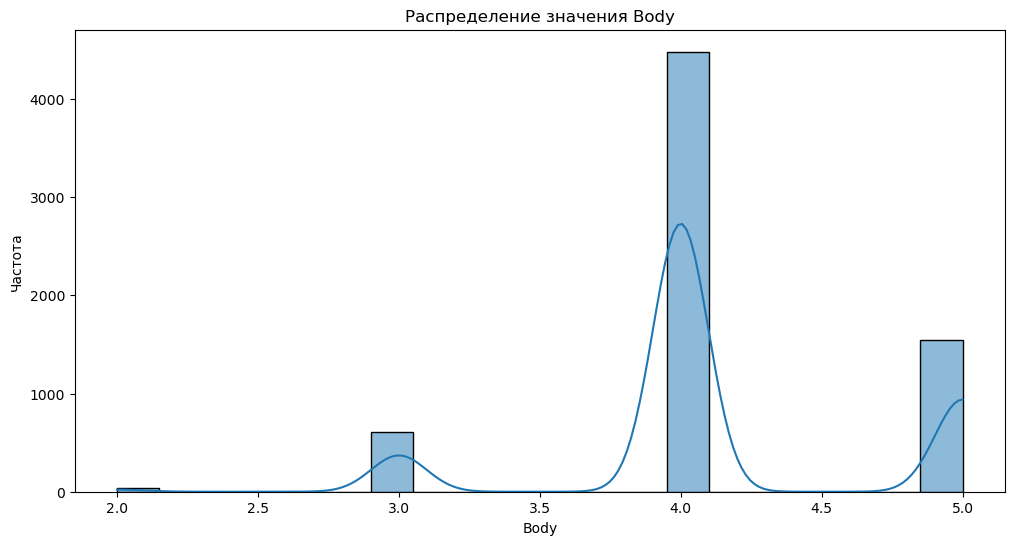

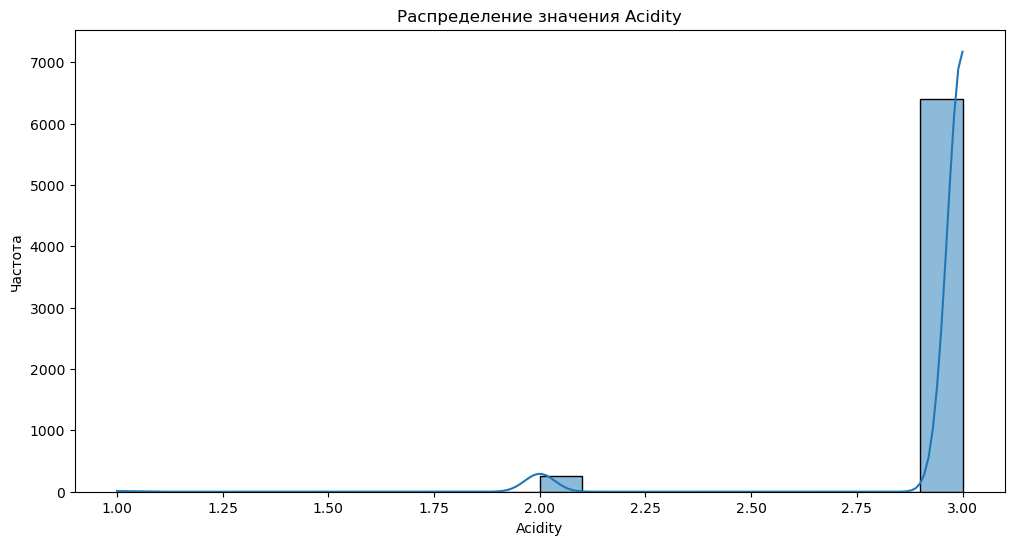

In [402]:
import matplotlib.pyplot as plt
import seaborn as sns

# Гистограмма для 'body'
plt.figure(figsize=(12, 6))
sns.histplot(data['body'], kde=True, bins=20)
plt.title('Распределение значения Body')
plt.xlabel('Body')
plt.ylabel('Частота')
plt.show()

# Гистограмма для 'acidity'
plt.figure(figsize=(12, 6))
sns.histplot(data['acidity'], kde=True, bins=20)
plt.title('Распределение значения Acidity')
plt.xlabel('Acidity')
plt.ylabel('Частота')
plt.show()


Возраст вина для нас важнее абсолютного года, поэтому введём новый признак `wine_age`

In [403]:
import datetime

current_year = datetime.datetime.now().year

data['year'] = data['year'].astype(np.int64)
data['wine_age'] = current_year - data['year']

print(data[['year', 'wine_age']].head())

data = data.drop(columns=['year'])
print(data.head())

    year  wine_age
69  2015         9
76  2015         9
79  2016         8
87  2015         9
89  2017         7
                  winery                          wine  rating  num_reviews  \
69   Pago de Carraovejas                     El Anejon     4.7          543   
76    Vinedos de Paganos                      La Nieta     4.7          312   
79           Emilio Moro     Malleolus de Valderramiro     4.7          300   
87  Quinta de la Quietud         La Mula de la Quietud     4.7          256   
89         Bodegas Mauro  Terreus Paraje de Cueva Baja     4.7          251   

              region  price                  type  body  acidity  wine_age  
69  Ribera del Duero  75.10  Ribera Del Duero Red   5.0      3.0         9  
76             Rioja  82.58             Rioja Red   4.0      3.0         9  
79  Ribera del Duero  84.95  Ribera Del Duero Red   5.0      3.0         8  
87              Toro  63.75              Toro Red   5.0      3.0         9  
89   Castilla y Leon  66.0

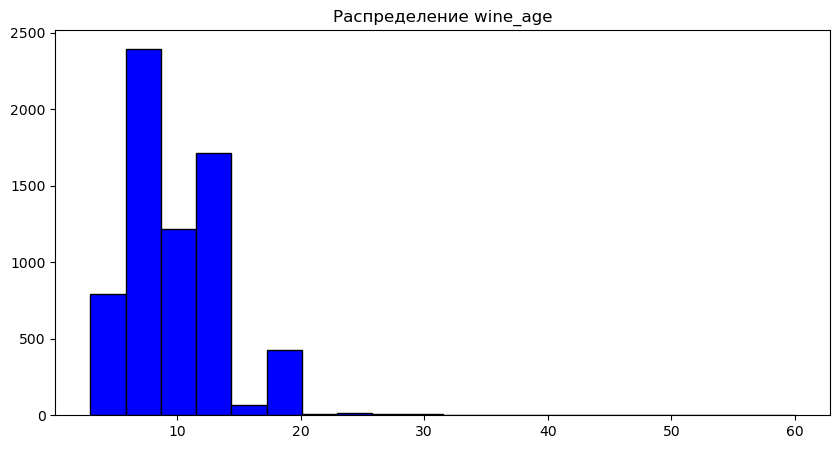

In [404]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(data['wine_age'], bins=20, color='blue', edgecolor='black')
plt.title('Распределение wine_age')
plt.show()


## 6. Нормализация и стандартизация признаков

In [405]:
from sklearn.preprocessing import StandardScaler

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

print(data.head())


                  winery                          wine    rating  num_reviews  \
69   Pago de Carraovejas                     El Anejon  5.718279     0.160701   
76    Vinedos de Paganos                      La Nieta  5.718279    -0.236218   
79           Emilio Moro     Malleolus de Valderramiro  5.718279    -0.256837   
87  Quinta de la Quietud         La Mula de la Quietud  5.718279    -0.332441   
89         Bodegas Mauro  Terreus Paraje de Cueva Baja  5.718279    -0.341032   

              region     price                  type      body   acidity  \
69  Ribera del Duero  1.960803  Ribera Del Duero Red  1.523258  0.202319   
76             Rioja  2.330587             Rioja Red -0.226874  0.202319   
79  Ribera del Duero  2.447751  Ribera Del Duero Red  1.523258  0.202319   
87              Toro  1.399702              Toro Red  1.523258  0.202319   
89   Castilla y Leon  1.514394           Tempranillo -0.226874 -4.630864   

    wine_age  
69 -0.152140  
76 -0.152140  
79 -0.38476

In [406]:
categorical_columns = [col for col in data.columns if data[col].dtype in ['object', 'category']]

# Применяем Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in categorical_columns:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])

print(data.head())


    winery  wine    rating  num_reviews  region     price  type      body  \
69     307   179  5.718279     0.160701      46  1.960803    11  1.523258   
76     403   315  5.718279    -0.236218      48  2.330587    12 -0.226874   
79     172   354  5.718279    -0.256837      46  2.447751    11  1.523258   
87     333   313  5.718279    -0.332441      58  1.399702    18  1.523258   
89      79   588  5.718279    -0.341032      14  1.514394    17 -0.226874   

     acidity  wine_age  
69  0.202319 -0.152140  
76  0.202319 -0.152140  
79  0.202319 -0.384766  
87  0.202319 -0.152140  
89 -4.630864 -0.617392  


In [407]:
data[categorical_columns] = scaler.fit_transform(data[categorical_columns])

print(data.head())

      winery      wine    rating  num_reviews    region     price      type  \
69  0.748215 -1.083137  5.718279     0.160701  0.334029  1.960803  0.060608   
76  1.608659 -0.312818  5.718279    -0.236218  0.474908  2.330587  0.355035   
79 -0.461786 -0.091918  5.718279    -0.256837  0.334029  2.447751  0.060608   
87  0.981252 -0.324146  5.718279    -0.332441  1.179301  1.399702  2.121597   
89 -1.295341  1.233485  5.718279    -0.341032 -1.920029  1.514394  1.827170   

        body   acidity  wine_age  
69  1.523258  0.202319 -0.152140  
76 -0.226874  0.202319 -0.152140  
79  1.523258  0.202319 -0.384766  
87  1.523258  0.202319 -0.152140  
89 -0.226874 -4.630864 -0.617392  


## 7. Разделение данных на обучающую и тестовую выборки

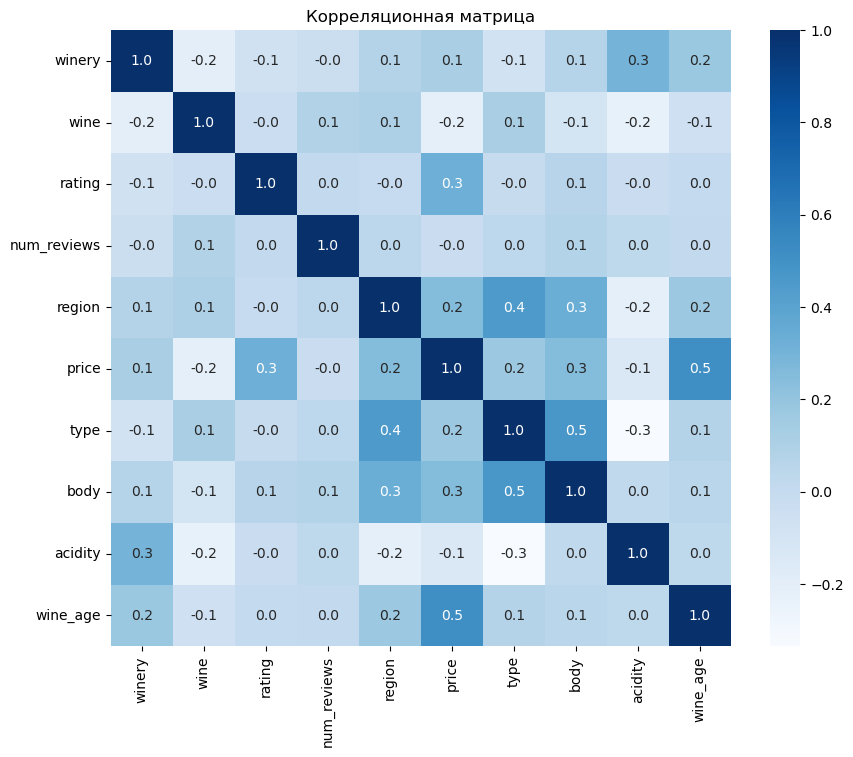

In [408]:

corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.1f')
plt.title("Корреляционная матрица")
plt.show()

In [409]:
from sklearn.model_selection import train_test_split

# Разделение данных
X = data.drop(columns=['price'])
y = data['price']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [410]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [411]:
results = {
    'Model': ['Linear Regression', 'Random Forest', 'KNN'],
    'MSE (Before tuning)': [None, None, None],
    'RMSE (Before tuning)': [None, None, None],
    'R^2 (Before tuning)': [None, None, None],
    'MSE (After tuning)': [None, None, None],
    'RMSE (After tuning)': [None, None, None],
    'R^2 (After tuning)': [None, None, None],
}

## 8. Линейная регрессия

In [412]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['MSE (Before tuning)'][0] = mse
results['RMSE (Before tuning)'][0] = rmse
results['R^2 (Before tuning)'][0] = r2

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 0.552626640034916
Root Mean Squared Error (RMSE): 0.7433886197910996
R^2 Score: 0.4454633487830816


Если цена вина обычно варьируется в диапазоне от 0 до 5 (или в вашем масштабе данных), ошибка 0.7434 — это около 15% от среднего значения, что считается умеренной точностью

In [413]:
# Параметры модели
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
print(coefficients.sort_values(by='Coefficient', ascending=False))


       Feature  Coefficient
8     wine_age     0.475177
2       rating     0.305881
6         body     0.182541
4       region     0.092974
0       winery     0.054788
5         type    -0.030791
3  num_reviews    -0.042147
1         wine    -0.199993
7      acidity    -0.206714


Сделаем подбор альфа для Ridge-регрессии. 

In [414]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Лучший alpha: {best_alpha}")

best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['MSE (After tuning)'][0] = mse
results['RMSE (After tuning)'][0] = rmse
results['R^2 (After tuning)'][0] = r2

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Лучший alpha: 10
Mean Squared Error (MSE): 0.5524844395249048
Root Mean Squared Error (RMSE): 0.7432929701839678
R^2 Score: 0.44560604077241095


Похоже, модель слишком простая и подбор гиперпараметров никак не улучшил модель. Попробуем более сложные модели.

## 9. Случайный лес (Random Forest)

In [415]:
from sklearn import ensemble
rf_model = ensemble.RandomForestRegressor(n_estimators = 100)
rf_model.fit(X_train, y_train)

y_train_predict_rf = rf_model.predict(X_train)
y_test_predict_rf = rf_model.predict(X_test)

MSE_train_rf = mean_squared_error(y_train, y_train_predict_rf)
MSE_test_rf = mean_squared_error(y_test, y_test_predict_rf)
RMSE_train_rf = np.sqrt(MSE_train_rf)
RMSE_test_rf = np.sqrt(MSE_test_rf)
R2_score_rf = r2_score(y_test, y_test_predict_rf)

results['MSE (Before tuning)'][1] = MSE_test_rf
results['RMSE (Before tuning)'][1] = RMSE_test_rf
results['R^2 (Before tuning)'][1] = R2_score_rf

print(f"Mean Squared Error (MSE) на обучающей выборке: {MSE_train_rf}")
print(f"Mean Squared Error (MSE) на тестовой выборке: {MSE_test_rf}")
print(f"Root Mean Squared Error (RMSE) на тестовой выборке: {RMSE_test_rf}")
print(f"R^2 Score: {R2_score_rf}")

Mean Squared Error (MSE) на обучающей выборке: 0.02144608721987771
Mean Squared Error (MSE) на тестовой выборке: 0.1605018444179264
Root Mean Squared Error (RMSE) на тестовой выборке: 0.40062681440203973
R^2 Score: 0.8389434224306807


In [416]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['MSE (After tuning)'][1] = mse
results['RMSE (After tuning)'][1] = rmse
results['R^2 (After tuning)'][1] = r2

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Marina\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Marina\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Marina\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Marina\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Marina\anaconda3\Lib\site-

Mean Squared Error (MSE): 0.14387291445777417
Root Mean Squared Error (RMSE): 0.3793058323540177
R^2 Score: 0.855629825990308


## 10. Метод k ближайших соседей (kNN, k nearest neighbours)

In [417]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['MSE (Before tuning)'][2] = mse
results['RMSE (Before tuning)'][2] = rmse
results['R^2 (Before tuning)'][2] = r2

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 0.1929836280525673
Root Mean Squared Error (RMSE): 0.43929901895242984
R^2 Score: 0.8063493739042321


In [418]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsRegressor()

# GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_knn = KNeighborsRegressor(**best_params)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['MSE (After tuning)'][2] = mse
results['RMSE (After tuning)'][2] = rmse
results['R^2 (After tuning)'][2] = r2

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 0.15968710853971418
Root Mean Squared Error (RMSE): 0.39960869427442913
R^2 Score: 0.8397609742329274


## 11. Результаты

In [419]:
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))


            Model  MSE (Before tuning)  RMSE (Before tuning)  R^2 (Before tuning)  MSE (After tuning)  RMSE (After tuning)  R^2 (After tuning)
Linear Regression             0.552627              0.743389             0.445463            0.552484             0.743293            0.445606
    Random Forest             0.160502              0.400627             0.838943            0.143873             0.379306            0.855630
              KNN             0.192984              0.439299             0.806349            0.159687             0.399609            0.839761
